We will use the classification models of XGBoost to predict the profile of target customers.  
To proceed with the machine learning, we have to convert the categorical variables into numerical variables first using one hot encoding.

In [1]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
customerdata = pd.read_csv('customer_bank_marketing_data.csv')
customerdata

,age,job,marital,education,default,balance,housing,loan,deposit_num
0,59,administrative,married,secondary,no,2343,yes,no,1
1,56,administrative,married,secondary,no,45,no,no,1
2,41,technician,married,secondary,no,1270,yes,no,1
3,55,services,married,secondary,no,2476,yes,no,1
4,54,administrative,married,tertiary,no,184,no,no,1
...,...,...,...,...,...,...,...,...,...
45202,59,management,married,tertiary,no,138,yes,yes,0
45203,37,management,married,tertiary,no,1428,no,no,0
45204,34,blue-collar,single,secondary,no,1475,yes,no,0
45205,57,blue-collar,married,secondary,no,668,no,no,0


# One Hot Encoding

In [4]:
#all categorical variables are converted into dummy variables using the pd.get_dummies function.
#each new added columns represents one category and contains 1 if the category is present.

catcols = ['job','marital','education','default','housing','loan']
for var in catcols:
    customerdata = pd.concat([customerdata.drop(var, axis=1), pd.get_dummies(customerdata[var], prefix=var, prefix_sep='_', drop_first=True, dummy_na=False, dtype=int)], axis=1)
customerdata   

,age,balance,deposit_num,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,59,2343,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,56,45,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,41,1270,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,55,2476,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,54,184,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,59,138,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,1
45203,37,1428,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
45204,34,1475,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
45205,57,668,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


# XGBoost Model Training

In [5]:
#the dataframe x will contain all the independent variables
#the dataframe y will only contain the dependent variable -> deposit_num

x = customerdata.drop(columns = 'deposit_num')
y = customerdata[['deposit_num']]
customerdata

,age,balance,deposit_num,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,59,2343,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,56,45,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,41,1270,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,55,2476,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,54,184,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,59,138,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,1
45203,37,1428,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
45204,34,1475,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
45205,57,668,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [6]:
#the test size is set to 30% of the data
#random state is set to ensure the reproducibility of results.
#it allows us to obtain the same random behaviour everytime we run the code

test_size = 0.3
rand_state = 40

In [7]:
#train XGBoost model

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=rand_state)

xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=1.0, colsample_bytree=1, max_depth=7)
xgb.fit(x_train, y_train.squeeze().values)
y_train_pred = xgb.predict(x_train)
y_test_pred = xgb.predict(x_test)

print('XGB accuracy score for ')
print('train: %.3f ' % (accuracy_score(y_train, y_train_pred)))
print('test: %.3f' % (accuracy_score(y_test, y_test_pred)))

XGB accuracy score for 
train: 0.892 
test: 0.879


n_estimators - represent the number of trees to build. Higher values allow the model to learn more complex patterns but can increase the risk of overfitting

learning_rate - controls the step size at each iteration while finding minimum cost function. Lower value make the model training more robust

gamma - specify the minimum loss reduction required to make a further partition on a leaf node.

subsample - determine the fraction of samples to be used for training each tree

colsample_bytree - determines the fraction of columns to be randomly sampled and used to build each tree

max_depth - set the maximum depth of the tree

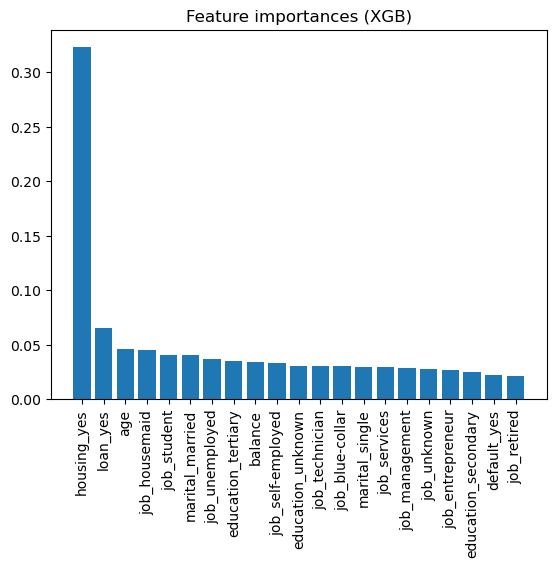

In [8]:
headers = ["name", "score"]
values = sorted(zip(x_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns=headers)

x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation = 90)
plt.title('Feature importances (XGB)')

plt.show()

From the graph, we can see that the top 3 variables that we can used to estimate our target customers would be housing_yes, loan_yes and age.

# Finding Optimum Value

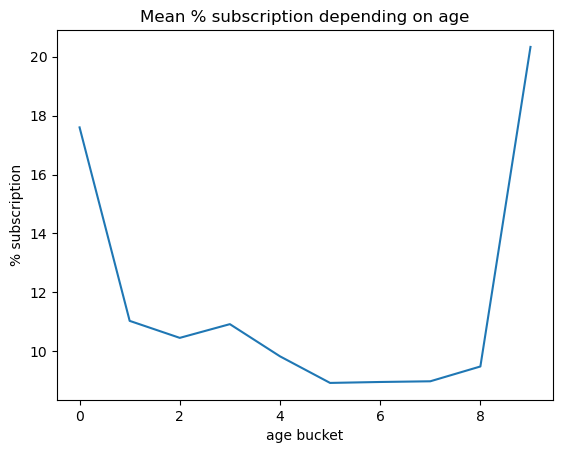

In [9]:
customerdata_new = customerdata.copy()

customerdata_new['age_buckets'] = pd.qcut(customerdata_new['age'], 10, labels=False, duplicates='drop')
mean_deposit = customerdata_new.groupby(['age_buckets'])['deposit_num'].mean()

plt.plot(mean_deposit.index, mean_deposit.values*100)
plt.title('Mean % subscription depending on age')
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

In [10]:
customerdata_new[customerdata_new['age_buckets']==1]['age'].max()


32

In [11]:
customerdata_new[customerdata_new['age_buckets']==8]['age'].min()

52

We can see that the average deposit percentage tends to be higher for customers below 32 years old or above 56 years old

# Conclusion from XGBoost

From the machine leraning model of XGBoost:

Whether the customers have a housing loan or not has a huge influence on the deposit success rate. People with housing loan are more likely to subscribe for a deposit. This is could be due to reasos such as these customers being more financially stable or having a higher propensity for long-term financial planning since they can afford buying a house.

Customers with personal loan are also more likely to subscribe for a term deposit. Customer from this category have to pay back the amount of money to the bank.  

The customers's age affects the campaign outcome as well. Future campaigns can concentrate on customers from age categories below 32 years old and above 52 years old. This isbecause younger customers may be more perceptive to financial planning early in their careers  while older customers may prioritize savings and investment for retirement.



Hence, we might expect our potential customers have housing loan, personal loan and age below 32 and above 52.